**<font size="5">Personality prediction based on internet posts</font>**

In this notebook we will investigate data from kaggle Myers-Briggs Personality Type Dataset. Based on information contained in this collection we will try to predict personality type of author of post.

More on test and personality types can be found here: https://www.16personalities.com/personality-types


**<font size="3">Buissnes understanding</font>**

Living in the internet world, we read hundreds of posts every day by authors with different views and character traits. Having data that collects posts labeled with the personality type of the user who wrote them I decided to answer the three below questions:

1. What is the distribution of each personality trait among forum users?
2. Are there any most significant word for every trait? Do extroverts write in a different way than introverts? Or maybe people with more sensitive approach are using emotional vocabulary?
3. Can personality type be predicted based on someones post?

Thanks to this recruiters could get to know potential job candidates better, based on the information they have provided about themselves, e.g. on Linkedin. This could also be used on dating sites, where machine learning algorithms could select partners based on their personality, inferred from their descriptions about themselves.

In [1]:
# import all necessary packages
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

**<font size="3">Data understanding & Data preparation</font>**

In [5]:
# load and display data
pd.options.display.max_colwidth = 100

data_df = pd.read_csv("../input/mbti-type/mbti_1.csv")
data_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi do...
8671,ENFP,'So...if this thread already exists someplace else (which it does: http://personalitycafe.com/e...
8672,INTP,'So many questions when i do these things. I would take the purple pill. Pick winning lottery n...
8673,INFP,'I am very conflicted right now when it comes to wanting children. I honestly had no maternal i...


In [3]:
# check if there are missing values
data_df.isna().mean()

type     0.0
posts    0.0
dtype: float64

Dataset consists of 2 columns with 8675 records. Every record contains authors personality type and his or hers published posts. It doesn't have any empty values so we don't need to worry about dropping or imputing missing data.

Let's display first 1000 characters of random record.

In [6]:
random_record = data_df.loc[42]["type"], data_df.loc[42]["posts"]
print("type: ", random_record[0], "\nposts: ", random_record[1][:1000])

type:  INTP 
posts:  Painting the world with the colors of my soul. Interpret it as you like - helping others by volunteering, teaching, giving everything you have.  Personal growth - learning as much about the universe...|||6 months ago I met this ENTP guy at my university. We are in the same group, so we basically have to be together everyday, and most likely have to study together for the next 6 years. So cutting off...|||1984 all the way|||I don't like people in groups because it's harder to enslave them.|||ESxJ or ISxJ, because I've noticed that ISxJs don't have much trouble with small talk either.  I'd say ISTJ.|||secret :)|||I really like the movie, and Alice is my alter ego in internet, since people find my real name a bit weird.|||Sense of smell easily, because my sense of smell has always been kind of weak. I think it's better that way, because I don't feel and suffer from disgusting smells people seem to feel everyday. I...|||I don't think there's a certain type who would te

Ok so before applying any modification to data we check how does the distribution of every type in dataset looks like

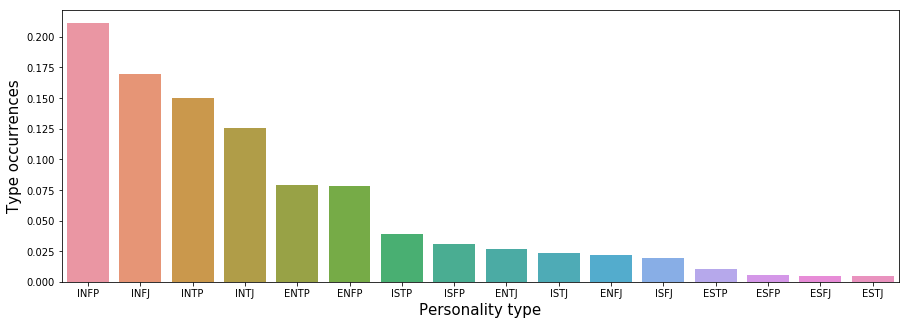

In [8]:
def plot_dist(data_dist, save_fig=False):
    """
    Plots seaborn barplot
    args: data_dist is a dictionary with trait name as key and it's occurences as value
          save_fig is boolean incitacing if figure should be saved as png file
    """
    fig = plt.figure(figsize=(15,5))
    sns.barplot(data_dist.index, data_dist.values)
    plt.ylabel('Type occurrences', fontsize=15)
    plt.xlabel('Personality type', fontsize=15)
    
    if save_fig:
        fig.savefig('distribution.png')
        
plot_dist(data_df["type"].value_counts(normalize=True), save_fig=True)

Well this is... interesting. It seems that we have much more introverts going throug life with strong intution (first two letters in personality type) in society. But is this accurate with official statistics? Not really, here: https://www.myersbriggs.org/my-mbti-personality-type/my-mbti-results/how-frequent-is-my-type.htm?bhcp=1 we can se that out dataset is not quite representative for whole society and because of that is strongly imbalanced.

According to graphics presented above we should investigate what is the distribution between each singular trait in our data. That means we want to check how looks a ratio:
* introverts to extraverts,
* intuition to sensing,
* feeling to thinking,
* judging to perceiving

To do that, let's encode our labels to categorized values.

In [9]:
def encode(personality):
    """Given string with four uppercase letters, returns list of int values: 1 for every letter (I, N, F, P), 0 otherwise"""
    encoder = defaultdict(int, {"I": 1, "N": 1, "F": 1, "P": 1})
    return [encoder[letter] for letter in list(personality)]

print(encode("ENTP"))
print(encode("ISFJ"))

[0, 1, 0, 1]
[1, 0, 1, 0]


In [10]:
data_df = pd.concat([pd.DataFrame.from_records(data_df["type"].apply(lambda personality: encode(personality)), columns=["I-E", "N-S", "F-T", "P-J"]), data_df], axis=1)
data_df

,I-E,N-S,F-T,P-J,type,posts
0,1,1,1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1ro...
1,0,1,0,1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the sam...
2,1,1,0,1,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I kno..."
3,1,1,0,0,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of th..."
4,0,1,0,0,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to b...
...,...,...,...,...,...,...
8670,1,0,1,1,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908|||IxFP just because I always think of cats as Fi do...
8671,0,1,1,1,ENFP,'So...if this thread already exists someplace else (which it does: http://personalitycafe.com/e...
8672,1,1,0,1,INTP,'So many questions when i do these things. I would take the purple pill. Pick winning lottery n...
8673,1,1,1,1,INFP,'I am very conflicted right now when it comes to wanting children. I honestly had no maternal i...


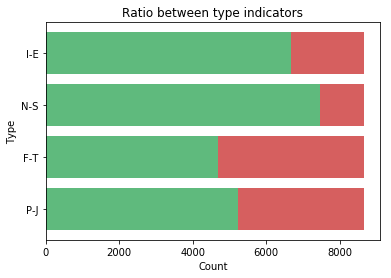

<Figure size 432x288 with 0 Axes>

In [12]:
left = np.array([data_df["I-E"].sum(), data_df["N-S"].sum(), data_df["F-T"].sum(), data_df["P-J"].sum()])
right = np.array([len(data_df)] * 4) - left

coordinates = [3, 2, 1, 0]

p1 = plt.barh(coordinates, left, color=['#5fba7d'])
p2 = plt.barh(coordinates, right, left=left, color=['#d65f5f'])

plt.title("Ratio between type indicators")
plt.xlabel("Count")
plt.ylabel("Type")
plt.yticks(coordinates, ("I-E", "N-S", "F-T", "P-J"))

plt.show()
plt.savefig("ratio.png")

Ok, so we can see that distribution is nothing like provided by test authors. Reason of this incompatibility may be related to fact that introverts are much more focused on their "inside world". So they tended to patricipate and discuss this kind of tests more offen than more expresive colleuges. Although I have no idea why this selected group of people are so insensitive :(

Now we should investigate text data but right now it looks a little bit messy. It seems that every post is separated by "|||" sign and it has a lot of redundant signs and traits which make analisys harder. We should clean up this text.

We would like to get rid of every:
* url
* digits
* non ascii characters
* most common words in certain language

And also:
* lowercase our text
* as well as lemmatize every word

In [13]:
def lemmatize_text(text):
    lem = WordNetLemmatizer()
    text = text.split(" ")
    text = [lem.lemmatize(word) for word in text]
    
    return " ".join(text)

def remove_stopwords(text, stopwords):
    text = text.split(" ")
    return " ".join([word for word in text if word not in stopwords])

def preprocess_text(text, stopwords):
    text = re.sub(r'http\S+', '', text)  # remove url links
    text = re.sub("[^a-zA-Z]", " ", text)  # remove every non ascii character and digit
    text = text.lower()
    text = remove_stopwords(text, stopwords)
    text = lemmatize_text(text)
    
    text = re.sub(' +', ' ', text)  # remove extra whitespaces
    return text

def simple_processing(text, types):
    text = re.sub(r'http\S+', '', text)  # remove url links
    text = re.sub("[^a-zA-Z]", " ", text)  # remove every non ascii character and digit
    text = text.lower()
    text = remove_stopwords(text, types)
    
    return text

Let's see how does above function affects out text

In [14]:
eng_stopwords = stopwords.words("english")
personality_types = list({type.lower() for type in set(data_df["type"])})
personality_types.extend([pt + "s" for pt in personality_types]) # a lot of people are using personality type in plural form with extra s at the end, we should remove it as well
my_stopwords = set(eng_stopwords).union(personality_types)  # we don't want to keep personality type acronyms in text, so we add them to stopwords

rnd_idx = np.random.randint(low=0, high=len(data_df)-1, size=2)
for idx in rnd_idx:
    random_record = data_df.loc[idx]["type"], data_df.loc[idx]["posts"]
    print("type: ", random_record[0], "\nposts: ", preprocess_text(random_record[1], my_stopwords), "\n")

type:  INFP 
posts:   friendship relationship trying understand better nfs especially done twice always big city helped felt could alone still feeding energy current humanity around might try want scare maybe see moment feel right already deep conversation go thank tried physical attraction feeling become boring time strong emotional attraction turn equally strong physical attraction closest friend relationship unfortunately always ended well much strong sometimes far come kind thing ask anyone acknowledge notice one thing hate people texting talking calling bothering working busy time even people love worst make angry think pretty generous word wise know wish could generous term physical touch shy often afraid unwelcome quality time much wish could act service know always seems everything covered try stuff anyway list interesting thinking know feel strongly certain subject feel strongly something really say thing best treasured thing anyone ever said trouble word affirmation gift givi

It's a lot of text, but it looks much cleaner. Now we will apply this function and clean text for every row in posts column. This may took around minute or two.

In [15]:
data_df["preprocessed_posts"] = data_df["posts"].apply(lambda text: preprocess_text(text, my_stopwords))
data_df["posts"] = data_df["posts"].apply(lambda text: simple_processing(text, personality_types))
data_df

,I-E,N-S,F-T,P-J,type,posts,preprocessed_posts
0,1,1,1,0,INFJ,and moments sportscenter not top ten plays pranks what has been the most life changing...,moment sportscenter top ten play prank life changing experience life repeat today may perc expe...
1,0,1,0,1,ENTP,i m finding the lack of me in these posts very alarming sex can be boring if it s in the sam...,finding lack post alarming sex boring position often example girlfriend currently environment c...
2,1,1,0,1,INTP,good one course to which i say i know that s my blessing and my curse does being...,good one course say know blessing curse absolutely positive best friend could amazing couple co...
3,1,1,0,0,INTJ,dear i enjoyed our conversation the other day esoteric gabbing about the nature of the uni...,dear enjoyed conversation day esoteric gabbing nature universe idea every rule social code arbi...
4,0,1,0,0,ENTJ,you re fired that s another silly misconception that approaching is logically is going to b...,fired another silly misconception approaching logically going key unlocking whatever think enti...
...,...,...,...,...,...,...,...
8670,1,0,1,1,ISFP,just because i always think of cats as fi doms for some reason on websites that have becom...,always think cat fi doms reason website become neo nazi perc nerd learning dutch duolingo much ...
8671,0,1,1,1,ENFP,so if this thread already exists someplace else which it does how the heck to i delete th...,thread already exists someplace else heck delete one ooops guess look hard started movie every ...
8672,1,1,0,1,INTP,so many questions when i do these things i would take the purple pill pick winning lottery n...,many question thing would take purple pill pick winning lottery number whatever want worked bre...
8673,1,1,1,1,INFP,i am very conflicted right now when it comes to wanting children i honestly had no maternal i...,conflicted right come wanting child honestly maternal instinct whatsoever recently none close f...


We can check what are the most common words between each group.

In [16]:
introverts_vocab = data_df.loc[data_df["I-E"] == 1]["preprocessed_posts"].sum().split(" ")
extraverts_vocab = data_df.loc[data_df["I-E"] == 0]["preprocessed_posts"].sum().split(" ")
feelers_vocab = data_df.loc[data_df["F-T"] == 1]["preprocessed_posts"].sum().split(" ")
thinkers_vocab = data_df.loc[data_df["F-T"] == 0]["preprocessed_posts"].sum().split(" ")

In [17]:
def get_top_n_words(corpus, n=None):
    """Gets n most common words from corpus"""
    words_freq = FreqDist(corpus)
    return words_freq.most_common(n)

In [18]:
def show_most_common_words(vocabulary):
    """Plots most common words in vocabulary as bar plot, with descending order"""
    top_words = get_top_n_words(vocabulary, n=20)
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Word", "Freq"]

    sns.set(rc={'figure.figsize':(13,8)})
    g = sns.barplot(x="Word", y="Freq", data=top_df);
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

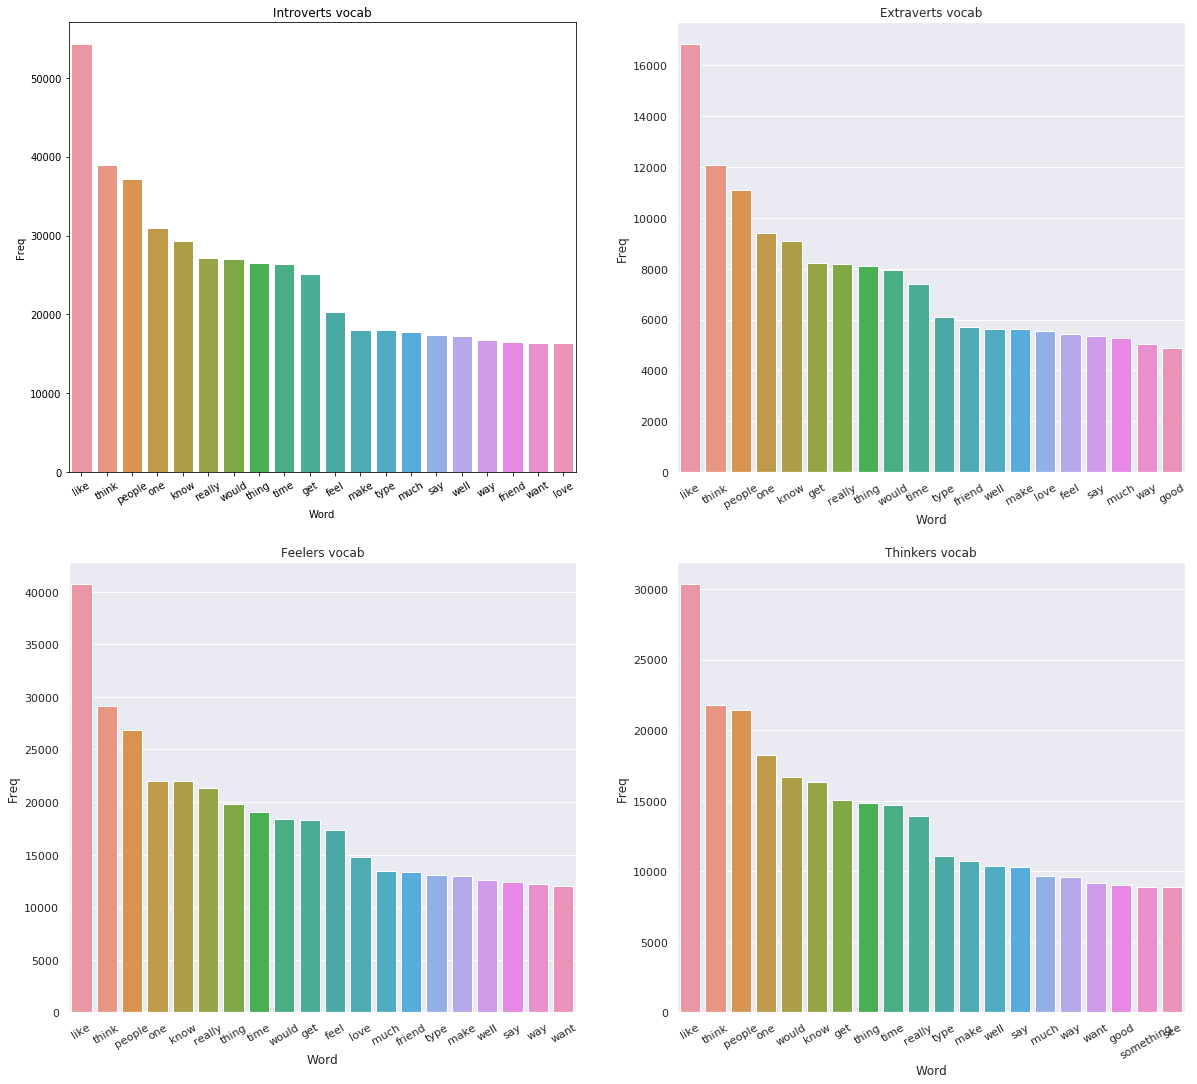

In [19]:
f = plt.figure(figsize=(20,10))
f.tight_layout()

f.add_subplot(4, 2, 1)
plt.title("Introverts vocab")
show_most_common_words(introverts_vocab)

f.add_subplot(4, 2, 2)
plt.title("Extraverts vocab")
show_most_common_words(extraverts_vocab)

plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=None)

f.add_subplot(4, 2, 3)
plt.title("Feelers vocab")
show_most_common_words(feelers_vocab)

f.add_subplot(4, 2, 4)
plt.title("Thinkers vocab")
show_most_common_words(thinkers_vocab)

So we can see that there is no clearly more popular words for each personality trait. We could remove ones which are most popular among each group, but maybe there is better way. Let's change text representation to numbers.

In [20]:
cv = CountVectorizer(max_df=0.90, max_features=10000, ngram_range=(1,1))
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)

X = cv.fit_transform(data_df["preprocessed_posts"])
feature_names = cv.get_feature_names()

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_vector = tfidf_transformer.fit_transform(X)

In [25]:
print(tfidf_vector.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Now when we have our data ready to use with machine learning algorighm we can train our model and see how it's behaves

**<font size="3">Modeling</font>**

In [21]:
l_svc = LinearSVC(C=100, verbose=3, max_iter=10000)

In [22]:
X = tfidf_vector
y = data_df["I-E"]

# beacuse of highly imbalanced dataset, we need to use stratify option, to make sure that each class representation will be accurate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# check if data is properly splitted
print(X_train.shape)
print(X_test.shape)

(6940, 10000)
(1735, 10000)


In [26]:
l_svc.fit(X_train, y_train)
y_pred = l_svc.predict(X_test)

[LibLinear]

**<font size="3">Evaluation</font>**

Cell below will plot colorful confusion matrix for results predicted by classifier

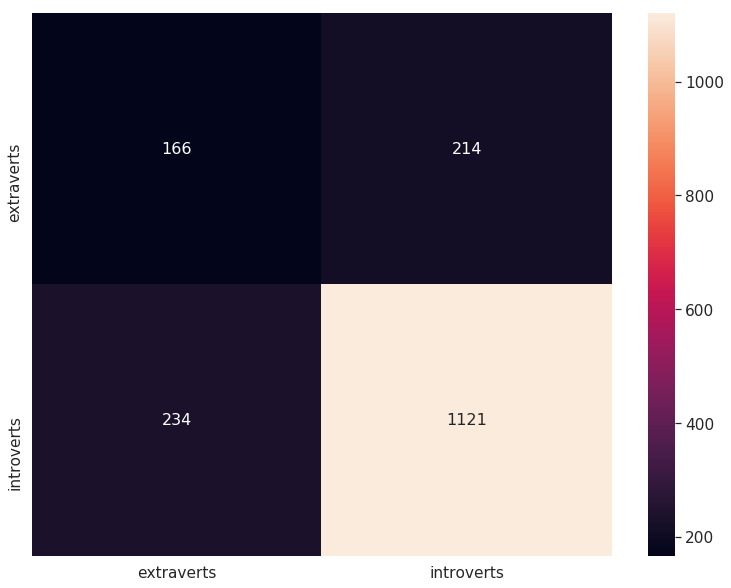

In [27]:
types_list = ["extraverts", "introverts"]
cm = confusion_matrix(y_pred, y_test)

df_cm = pd.DataFrame(cm, types_list, types_list)
fig = plt.figure(figsize = (13,10))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')

plt.show()

More detailed report

In [28]:
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.44      0.43       380
           1       0.84      0.83      0.83      1355

    accuracy                           0.74      1735
   macro avg       0.63      0.63      0.63      1735
weighted avg       0.75      0.74      0.74      1735



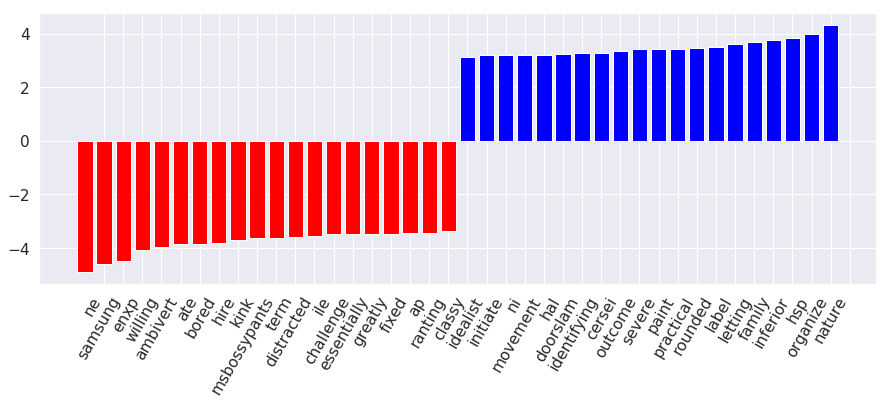

In [30]:
def plot_coefficients(classifier, feature_names, n_features=20):
    """Plots a bar plot with feature importances for provided classifier. To work classifier must have coef_ attribute"""
    coef = classifier.coef_.ravel()
    feature_names = np.array(feature_names)
    
    top_pos_coefficients = np.argsort(coef)[-n_features:]
    top_neg_coefficients = np.argsort(coef)[:n_features]
    top_coefficients = np.hstack([top_neg_coefficients, top_pos_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_features), coef[top_coefficients], color=colors)
    plt.xticks(np.arange(1, 1 + 2 * n_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()

plot_coefficients(l_svc, cv.get_feature_names())

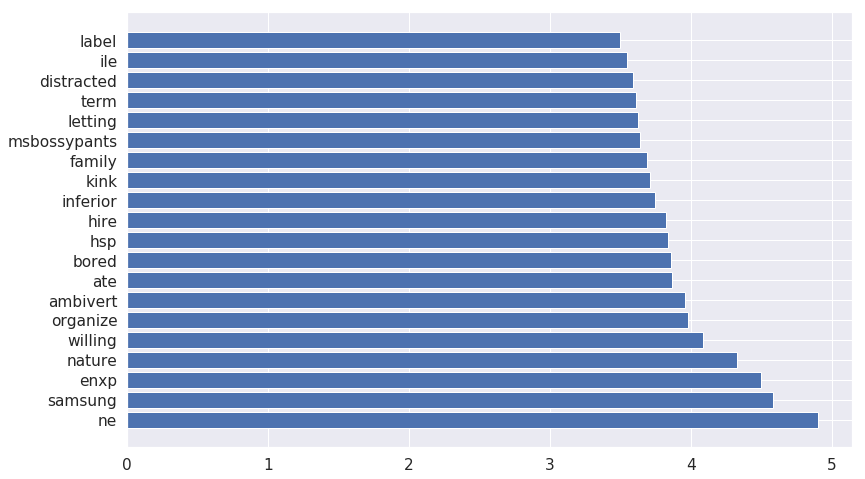

In [45]:
def feature_importances(coef, features_names, n_top=-1):
    coef, features_names = zip(*sorted(list(zip(coef, features_names))))

    # Show all features
    if n_top == -1:
        n_top = len(features_names)

    plt.barh(range(n_top), coef[::-1][0:n_top], align='center')
    plt.yticks(range(n_top), features_names[::-1][0:n_top])
    plt.show()

feature_importances(abs(l_svc.coef_[0]), cv.get_feature_names(), n_top=20)

Now we will train four different binary classifiers and print classification result for every one of them

Fitting I-E
[LibLinear]I-E  report
               precision    recall  f1-score   support

           0       0.44      0.47      0.46       373
           1       0.85      0.84      0.84      1362

    accuracy                           0.76      1735
   macro avg       0.65      0.65      0.65      1735
weighted avg       0.76      0.76      0.76      1735



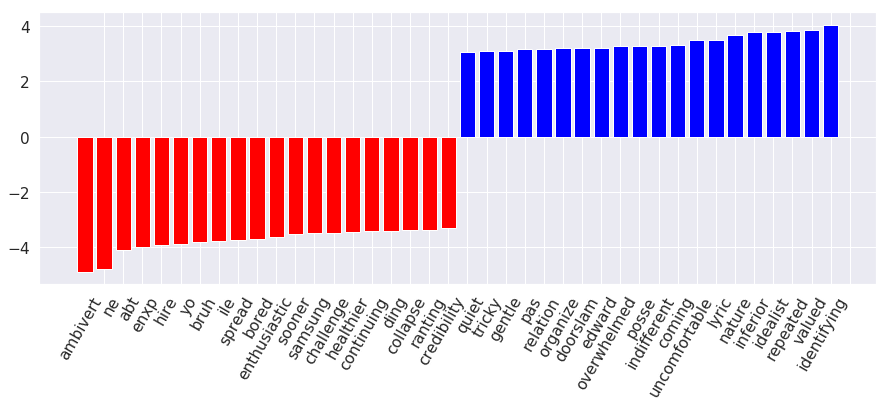

/n
Fitting N-S
[LibLinear]N-S  report
               precision    recall  f1-score   support

           0       0.28      0.35      0.31       194
           1       0.92      0.89      0.90      1541

    accuracy                           0.83      1735
   macro avg       0.60      0.62      0.61      1735
weighted avg       0.85      0.83      0.84      1735



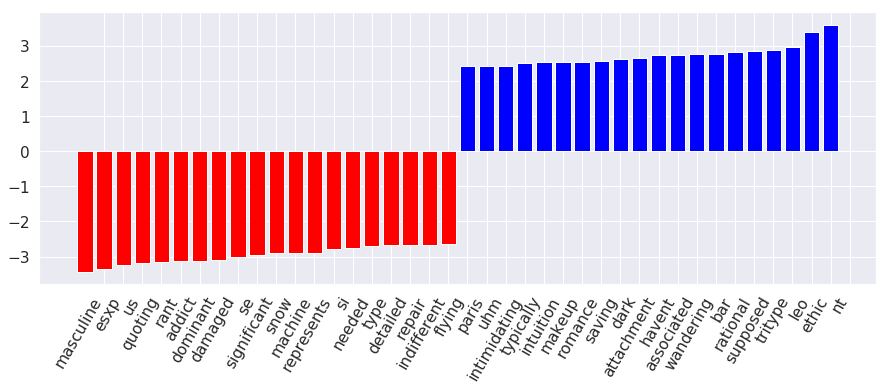

/n
Fitting F-T
[LibLinear]F-T  report
               precision    recall  f1-score   support

           0       0.72      0.73      0.73       791
           1       0.77      0.77      0.77       944

    accuracy                           0.75      1735
   macro avg       0.75      0.75      0.75      1735
weighted avg       0.75      0.75      0.75      1735



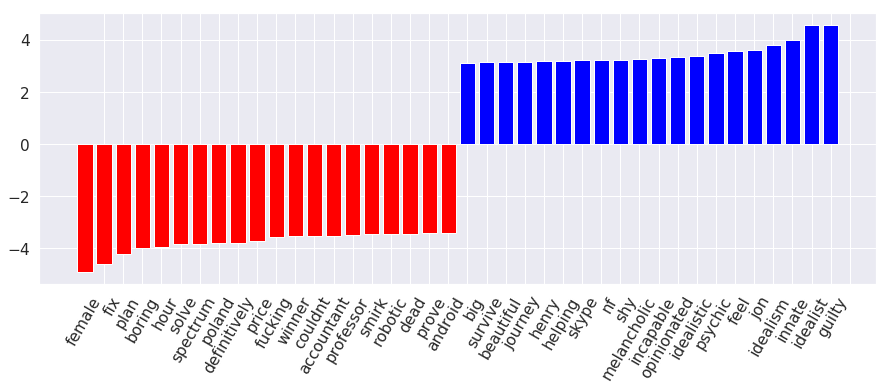

/n
Fitting P-J
[LibLinear]

In [ ]:
X = tfidf_vector
for type_trait in ("I-E", "N-S", "F-T", "P-J"):
    y = data_df[type_trait]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y, shuffle=True)
    
    print(f"Fitting {type_trait}")
    l_svc.fit(X_train, y_train)
    y_pred = l_svc.predict(X_test)
    report = classification_report(y_pred, y_test)
    print(type_trait, " report\n", report)
    plot_coefficients(l_svc, cv.get_feature_names())

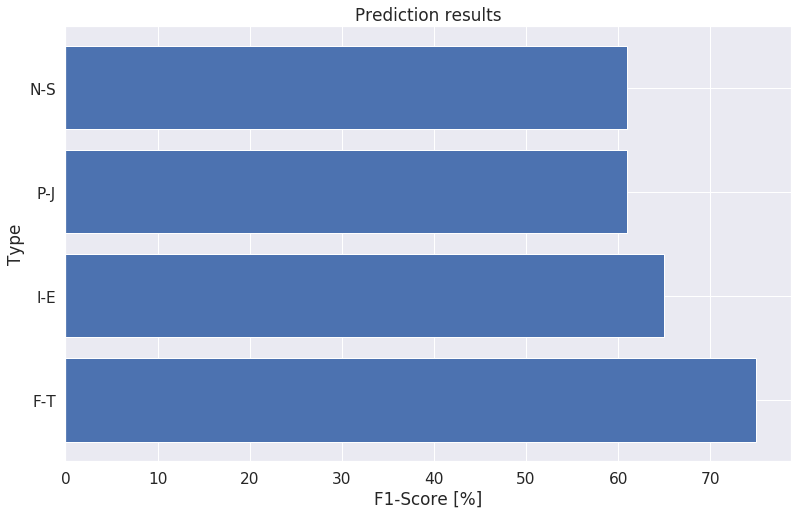

In [48]:
def show_results(values, names):
    """Visualize results by providing score values and classes names"""
    values = [value * 100 for value in values]
    values, names = zip(*sorted(list(zip(values, names))))
    
    plt.title("Prediction results")
    plt.xlabel("F1-Score [%]")
    plt.ylabel("Type")
    plt.barh(range(4), values[::-1][:], align='center')
    plt.yticks(range(4), names[::-1][:])
    plt.show()
    
show_results([0.65, 0.61, 0.75, 0.61], ["I-E", "N-S", "F-T", "P-J"])